In [2]:
%matplotlib notebook

[Table of Contents](table_of_contents.ipynb)

# Appendix A. Common Attitude Representations

[Introduction](#Introduction)

## Introduction

A point in 3D space can be thought of as a vector pointing from the origin to the point. This vector, when described in a frame of reference, is fully parameterized by three scalars. Being a vector, it inherits all of the beneficial mathematical properties of a vector space, including associativity and commutativity of addition, the identity and inverse elements, and scalar multiplication.

Attitude, on the other hand, is not so elegant. While it is true, that there are only three degrees of freedom to describe orientation, none of the representation methods form a global, minimum representation. Some behave like vector spaces, but are only local charts (e.g. Euler anges, Rodriguez) and others are global but are embedded in a higher dimensional space (e.g. rotation matrices, unit quaternions).

Here we will explore some of the most common methods for representing attitude and touch on their pros and cons. Much of this material is based on Shuster's work in
 * Shuster, M. D. (1993). A Survey of attitude representations. The Journal of the Astronautical Sciences, 1(4), 439–517.

## The Attitude Class

We shall define a class to help us visualize the attitude of a body (in this case an aircraft) as well as convert between methods of representation. We will use a rotation matrix as the base representation for reasons that will hopefully become clear.

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits import mplot3d

class Attitude:
    # This class will be used to convert between the many methods of representing attitude.
    # The base internal representation will be a rotation matrix, as it has the fewest
    # caveats and conversion to and from the rotation matrix is well understood.
    def __init__(self, R=np.eye(3)):
        self.R = R
        self.init_visualization()
        self._interact_options = {}
    
    @staticmethod
    def identity():
        return Attitude()
    
    def set_rotation_matrix(self, R):
        self.R = R
        self.update_vis()
        
    def init_visualization(self):
        # load and draw the plane
        self._plane = pickle.load(open("files/T38.p", "rb"))
        self._figure = plt.figure()
#         self._axes = plt.subplot2grid((6, 1), (0, 0), rowspan=5, projection='3d')
        self._axes = mplot3d.Axes3D(self._figure)
        self._axes.set_aspect('equal')
        scale = self._plane.points/np.max(self._plane.points).flatten('F')
        self._base_R = np.array([[0, 0, 1],
                                 [1, 0, 0],
                                 [0, -1, 0]])
        R = self.R.T.dot(self._base_R)
        vectors = np.einsum('ij,...j->...i', R, self._plane.vectors)/np.max(self._plane.points)
        self._faces = mplot3d.art3d.Poly3DCollection(vectors)
        self._faces.set_facecolor((0,0,1))
        self._faces.set_edgecolor((0.3, 0.3, 0.6))
        self._axes.add_collection3d(self._faces)
#         self._axes.auto_scale_xyz(scale, scale, scale)
        # Create cubic bounding box to simulate equal aspect ratio (this is a workaround)
        max_range = 2
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten()
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten()
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten()
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
           self._axes.plot([xb], [yb], [zb], 'w')
        self._axes.set_xlabel('North')
        self._axes.set_ylabel('East')
        self._axes.set_zlabel('Down')
        self._axes.invert_yaxis()
        self._axes.invert_zaxis()
        
        # draw the inertial frame
        self._axes.quiver([0,0,0],[0,0,0],[0,0,0],#[-1,-1,-1],[1,1,1],[1,1,1],
                    [1,0,0],[0,1,0],[0,0,1], 
                    colors=['r','g','b','r','r','g','g','b','b'], pivot='tail')
        
    def update_vis(self):
        R = self.R.T.dot(self._base_R)
        vectors = np.einsum('ij,...j->...i', R, self._plane.vectors)/np.max(self._plane.points)
        self._faces.set_verts(vectors)
        self._figure.canvas.draw_idle()
    
    def show(self):
        self._figure.show()


## Rotation Matrices

A rotation matrix, $R$, sometimes called a *direction-cosine matrix*, is a member of the *special orthogonal group*, i.e. $R \in SO(3)$, which is a subset of $3x3$ matrices. It has the requirements that its columns be linearly independent, or *orthogonal*, and it have a determinant equal to 1.

Let

$$
R = \begin{bmatrix}\mathbf{r}_1 & \mathbf{r}_2 & \mathbf{r}_3\end{bmatrix}
$$

then

$$
R \in SO(3) \subset \mathbb{R}^{3x3} \\
\Rightarrow Det(R) = 1 \\
\Rightarrow \langle \mathbf{r}_i, \mathbf{r}_j \rangle = \delta_{ij}
$$
where $\delta_{ij}$ is the Kronecker delta.

Multiplying a vector (or point) by a rotation matrix, simply rotates the the vector by some angle, $\vartheta$, about some axis, $\mathbf{n}$, and so the rotation matrix is sometimes written $R(\mathbf{n}, \vartheta)$. Now we need to pause for a moment and proceed carefully. There are two types of rotations [transformations]: [active and passive](https://en.wikipedia.org/wiki/Active_and_passive_transformation), or sometimes called *alibi* and *alias* transformations respectively. An example is shown below.

![Active left, Passive right](files/PassiveActive.jpg)

An active transformation (left image) literally moves the vector, within a specific frame of reference,

$$
\mathbf{p}^{0\prime} = R\mathbf{p}^0,
$$

while a passive rotation (right image) changes the frame of reference,

$$
\mathbf{p}^{1} = R_0^1\mathbf{p}^0,
$$

where the superscript denotes what frame the vector is expressed in. It can be said that $R_a^b$ transforms from frame $\mathcal{F}^a$ to $\mathcal{F}^b$, or its colunms can be thought of as the principle axes of $\mathcal{F}^a$ expressed in $\mathcal{F}^b$.

Unless explicitly stated, we shall use *passive rotations* for the remainder of this article.

The simplest rotations to visualize, is a rotation of some angle, $\vartheta$, through one of the principle axes, $\mathbf{i}$, $\mathbf{j}$, or $\mathbf{k}$ (x, y, and z-axes, respectively).

$$
R(\mathbf{i}, \vartheta) = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \vartheta  & sin \vartheta  \\
0 & -\sin \vartheta  & cos \vartheta 
\end{bmatrix}
$$

$$
R(\mathbf{j}, \vartheta) = 
\begin{bmatrix}
\cos \vartheta  & 0 & -sin \vartheta  \\
0 & 1 & 0 \\
\sin \vartheta  & 0 & cos \vartheta 
\end{bmatrix}
$$

$$
R(\mathbf{k}, \vartheta) = 
\begin{bmatrix}
\cos \vartheta & sin \vartheta & 0 \\
-\sin \vartheta & cos \vartheta & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

Rotations can also be composed to form a more complex rotation. If rotations are applied with respect to the [body-]fixed frame (i.e., each rotation is applied using an intermediate frame formed after the previous rotation), they are pre-multiplied to form the composite. This is the most common method of composing rotations:

$$
R_0^2 = R_1^2(\mathbf{n}_2^1, \vartheta_2) R_0^1(\mathbf{n}_1^0, \vartheta_1).
$$

In this scenario, the frame is first rotated by $\vartheta_1$ about the $\mathbf{n}_1$ axis, which is expressed in frame $\mathcal{F}^0$. It is then rotated by $\vartheta_2$ about the $\mathbf{n}_2$ axis, which is expressed in frame $\mathcal{F}^1$.

Alternatively (and less commonly), rotations can be applied about a single frame, so each successive rotation is about an axis in the original frame. This form of composition is done by post-multiplying:

$$
R_2^0 = R_1^0(\mathbf{n}_1^0, \vartheta_1) R_2^1(\mathbf{n}_2^0, \vartheta_2).??????
$$

Note that each rotation is about an axis expressed in the original frame $\mathcal{F}^0$.

In aircraft applications, we usually use passive rotations to express attitudes in different frames of reference (inertial, vehicle, body, etc.).

### Pros

 * Rotation matrices are the native representation for the 3D rotation group, $SO(3)$. As such, they are a global representation without singularities or discontinuities.
 * Matrix multiplication is heavily optimized on modern hardware, so most performance arguments are now moot.
 * $SO(3)$ is a Lie group and inherits all of its goodness (see rest of book).

### Cons

 * They can be hard to visualize mentally.
 * They are not a minimal representation (i.e., not a vector space) and cannot be used with linear numerical techniques like state-space models or Kalman filters.
 * Imperfect numerical techniques can lead to non-normalized and non-orthogonal matrices.

## Euler Angles

We can describe any rotation matrix in terms of three consecutive rotations about body-fixed (*intrinsic*) or inertailly-fixed (*extrinsic*) principle axes. Shuster focuses on body-fixed Euler axes.

$$
R_0^3(\mathbf{n}_1^0, \mathbf{n}_2^1, \mathbf{n}_3^2; \vartheta_1, \vartheta_2, \vartheta_3) = R_2^3(\mathbf{n}_3^2, \vartheta_3) R_1^2(\mathbf{n}_2^1, \vartheta_2) R_0^1(\mathbf{n}_1^0, \vartheta_1)
$$

By convention, the rotational axes are restricted to the principle axes; $\mathbf{i}$, $\mathbf{j}$, and $\mathbf{k}$ (alternately $\mathbf{1}$, $\mathbf{2}$, and $\mathbf{3}$ respectively). To preserve the three degrees of freedom found on the rotation manifold, $SO(3)$, we must apply the constraint

$$
\mathbf{n}_1 \neq \mathbf{n}_2 \quad \text{and} \quad \mathbf{n}_2 \neq \mathbf{n}_3.
$$

Given this constraint, there are 12 possible [Euler angles](https://en.wikipedia.org/wiki/Euler_angles) (24 if you count inertially-fixed rotations). There are six symmetric sets (sometimes called *Proper Euler angles*):

\begin{align*}
&121 \qquad \qquad \qquad & 131 \\
&232 & 212 \\
&313 & 323 \\
\end{align*}

and six asymmetric sets (sometimes called *Tait-Brian angles*):

\begin{align*}
&123 \qquad \qquad \qquad & 132 \\
&231 & 213 \\
&312 & 321 \\
\end{align*}

It can be shown that Euler angles are not unique, for example

$$
R_{313}(\phi, \theta, \psi) = R_{313}(\phi + \pi, -\theta, \psi + pi),
$$

so for Proper Euler angles we commonly apply the constraint

$$
0 \leq \phi < 2\pi, \qquad 0 \leq \theta \leq \pi, \qquad 0 \leq \psi < 2\pi,
$$

and for Tait-Bryan angles we apply

$$
-\pi \leq \phi < \pi, \qquad -\pi/2 \leq \theta \leq \pi/2, \qquad -\pi \leq \psi < \pi,
$$

We commonly describe an aircraft's attitude in yaw, pitch, and roll, which corresponds to the 321 body-fixed Tait-Bryan angles shown below.

<img src="files/Plane_NED_Euler.svg" alt="Drawing" style="width: 300px;"/>

### Converting to a rotation matrix

Simply use the composition rule and the rotations about principle axes in the above section. Many "pre-baked" matrices can be found in books or on the internet where you can just plug in $\phi$, $\theta$, and $\psi$. Caution is advised when using one of these sources because of the ease of confusion and ambiguity associated with rotation matrices that have already been composed from Euler angles. Which of the 12 axis orderings did they use? Was it body-fixed or inertial fixed? Instead, we strongly suggest one just compose their own from the elementary rotations above (just be careful about active vs. passive rotations).

### Extracting Euler angles from a rotation matrix

Again, this is a difficult subject, given the many options for Euler angles. Shuster provides a generic method for finding Euler angles given an arbitrary axis order on p. 458. Otherwise, one can algebraically multiply out the desired elementary rotations and solve for the desired angles.

### Pros

 * Very easy to visualize
 * Minimum representation
 * Can be treated like a vector space in most circumstances, enabling state-space modelling and direct Kalman filtering

### Cons
 * Composing Euler angles directly is nearly impossible.
 * Not a vector space, leads to numerical inaccuracies
 * Singularites, so difficult to use with satellites, acrobatic aircraft, many serial-link manipulators

In [4]:
from ipywidgets import interactive, Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import display

class Attitude(Attitude):
    def __init__(self, R=np.eye(3)):
        super().__init__(R)
        self._interact_options['euler'] = self.interact_euler
        
    def set_euler_angles(self, phi, theta, psi, order='321', body_fixed=True):
        # Note: these are passive notations
        c = np.cos
        s = np.sin
        rot_1 = lambda x: np.array([[1,     0,    0],
                                    [0,  c(x), s(x)],
                                    [0, -s(x), c(x)]])
        rot_2 = lambda x: np.array([[c(x), 0, -s(x)],
                                    [   0, 1,     0],
                                    [s(x), 0,  c(x)]])
        rot_3 = lambda x: np.array([[ c(x), s(x), 0],
                                    [-s(x), c(x), 0],
                                    [   0,     0, 1]])
        rots = {"1":rot_1, "2":rot_2, "3":rot_3}
        order = list(order)
        R = np.eye(3)
        if body_fixed:
            R = rots[order[0]](psi).dot(R)
            R = rots[order[1]](theta).dot(R)
            R = rots[order[2]](phi).dot(R)
        else:
            R = R.dot(rots[order[0]](psi))
            R = R.dot(rots[order[1]](theta))
            R = R.dot(rots[order[2]](phi))
        self.set_rotation_matrix(R)
        
    def euler_slider_update(self, psi, theta, phi):
        self.set_euler_angles(phi, theta, psi, self._order.value, self._body_fixed.value)
        
    def order_update(self, change):
        if change['type'] == 'change' and change['name'] == 'value':
            psi = self._sliders.children[0].value
            theta = self._sliders.children[1].value
            phi = self._sliders.children[2].value
            order = self._order.value
            body_fixed = self._body_fixed.value
            self.set_euler_angles(phi, theta, psi, order, body_fixed)
            
    def body_fixed_update(self, change):
        if change['type'] == 'change' and change['name'] == 'value':
            psi = self._sliders.children[0].value
            theta = self._sliders.children[1].value
            phi = self._sliders.children[2].value
            order = self._order.value
            body_fixed = self._body_fixed.value
            self.set_euler_angles(phi, theta, psi, order, body_fixed)
    
    def reset_psi(self, b):
        self._sliders.children[0].value = 0.0
        
    def reset_theta(self, b):
        self._sliders.children[1].value = 0.0
        
    def reset_phi(self, b):
        self._sliders.children[2].value = 0.0
        
    def reset_all_euler(self, b):
        self.reset_psi(None)
        self.reset_theta(None)
        self.reset_phi(None)
        self._order.value = '321'
        self._body_fixed.value = True
        
    def interact_euler(self):
        self._sliders = interactive(self.euler_slider_update, 
                                    psi=(-np.pi, np.pi), 
                                    theta=(-np.pi/2, np.pi/2), 
                                    phi=(-np.pi, np.pi))
        reset_psi = Button(description="reset")
        reset_theta = Button(description="reset")
        reset_phi = Button(description="reset")
        
        reset_psi.on_click(self.reset_psi)
        reset_theta.on_click(self.reset_theta)
        reset_phi.on_click(self.reset_phi)
        
        reset_buttons = VBox([reset_psi, reset_theta, reset_phi])
        # display(self._sliders)
        self._order = widgets.Dropdown(
            options=['121', '232', '313', '131', '212', '323', 
                     '123', '231', '312', '132', '213', '321'],
            value='321',
            description='Angle order:',
            disabled=False,
            )
        self._order.observe(self.order_update)
        
        self._body_fixed = widgets.Dropdown(
            options={"body-fixed":True, "inertial-fixed":False},
            value=True,
            description="Fixed frame:",
            disabled=False,
            )
        self._body_fixed.observe(self.body_fixed_update)
        
        menus = HBox([self._order, self._body_fixed])
        
        euler_controls = HBox([self._sliders, reset_buttons])
        
        reset_all = Button(description="reset all")
        reset_all.on_click(self.reset_all_euler)
        controls = VBox([menus, euler_controls, reset_all])
        display(controls)
        
    def show(self, style=None):
        super().show()
        if style is not None:
            self._interact_options[style]()

<IPython.core.display.Javascript object>


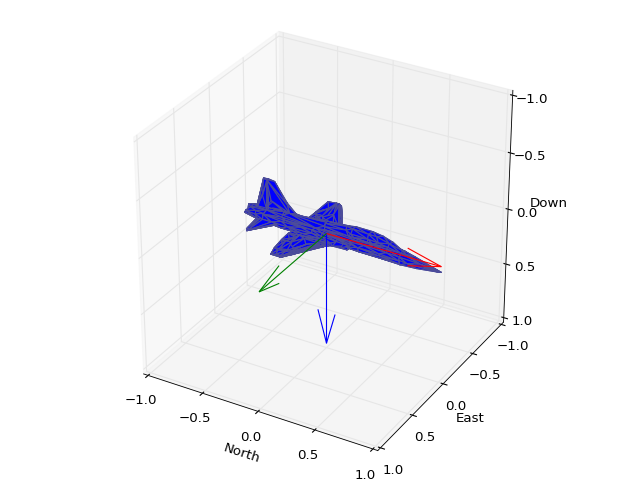

In [5]:
att = Attitude()
att.show('euler')

## Axis Angle

At this point, it should be clear that we can describe any rotation by specifying an angle, $\vartheta$ and an arbitrary unit vector axis, $\mathbf{n}$ about which to rotate, as seen below.

![Axis Angle](files/Angle_axis_vector.svg)

It is common practice to multiply the angle, $\theta$, into the unit vector, $\mathbf{n}$, element-wise to produce a minimal representation of the rotation, called the *rotation vector* $\boldsymbol{\theta}$, defined by

$$
\boldsymbol{\theta} = \theta \mathbf{n}
$$

### Derivation

Let us consider for a moment, the (active) rotation of an arbitrary vector, $\mathbf{v}$, about another arbitrary unit vector, $\mathbf{n}$, by angle $\theta$. If we take only the component of $\mathbf{v}$ perpendicular to $\mathbf{n}$, we can show that

$$
R(\mathbf{n}, \theta) \mathbf{v}_\bot = \cos\theta\mathbf{v}_\bot - \sin\theta[\mathbf{n}]_\times \mathbf{v}_\bot,
$$

where $[\mathbf{n}]_\times$ denotes embedding the vector $\mathbf{n}$ into a skew-symmetric matrix as

$$
[\mathbf{n}]_\times = \begin{bmatrix}
0 & -n_3 & n_2 \\
n_3 & 0 & -n_1 \\
-n_2 & n_1 & 0
\end{bmatrix}.
$$

It is worth noting, that the component of $\mathbf{v}$ parallel to $\mathbf{n}$, $\mathbf{v}_\parallel$ is unchanged by the rotation, so we can write

$$
R(\mathbf{n}, \theta) \mathbf{v} = \mathbf{v}_\parallel + \cos\theta\mathbf{v}_\bot - \sin\theta[\mathbf{n}]_\times \mathbf{v}_\bot.
$$

We can decompose $\mathbf{v}$ with respect to $\mathbf{n}$ as

$$
\begin{align*}
\mathbf{v} &= \mathbf{v}_\parallel + \mathbf{v}_\bot \\
&= \mathbf{n}\mathbf{n}^\top \mathbf{v} - \mathbf{n} \times (\mathbf{n} \times \mathbf{v}) \\
&= \mathbf{n}\mathbf{n}^\top \mathbf{v} - [\mathbf{n}]_\times^2 \mathbf{v}
\end{align*}.
$$

Substituting back in and using the fact that $\mathbf{v}$ is arbitrary we get

$$
\begin{align*}
R(\mathbf{n}, \theta) &= \mathbf{n}\mathbf{n}^\top - \cos \theta [\mathbf{n}]_\times^2 + \sin \theta [\mathbf{n}]_\times^3 \\
&= \mathbf{n}\mathbf{n}^\top - \cos \theta (\mathbf{n}\mathbf{n}^\top - I) - \sin \theta [\mathbf{n}]_\times \\
&= \cos \theta \, I + (1 - \cos \theta) \mathbf{n}\mathbf{n}^\top - \sin \theta [\mathbf{n}]_\times.
\end{align*}
$$

Equivalently,

$$
R(\mathbf{n}, \theta) = I - \sin \theta [\mathbf{n}]_\times + (1 - \cos \theta) [\mathbf{n}]_\times^2.
$$

### Relationship to the Lie Algebra $\mathfrak{so}(3)$

An important case is when the angle, $\theta$, is infinitesimally small and is usually written $\Delta \theta$, such that $\sin \Delta \theta \approx \Delta \theta$ and $\cos \Delta \theta \approx 1$. The above equation simplifies to

$$
R(\mathbf{n}, \theta) = I - [\boldsymbol{\Delta \theta}]_\times + O(|\boldsymbol{\Delta \theta}|^2).
$$

Ignoring higher-order terms, we can now write

$$
\begin{align}
R(\mathbf{n}, \theta) &= \lim_{N\rightarrow \infty} \left[ R(\mathbf{n}, \theta/N) \right]^N \\
 &= \lim_{N\rightarrow \infty} \left[ I + \frac{\theta}{N} [\mathbf{n}]_\times \right]^N \\
 &= \exp \{[\boldsymbol{\theta}]_\times\}.
 \end{align}
$$

Where $\exp \{ \cdot\}$ denotes the matrix exponential. By applying the Taylor series expansion and simplifying, we can again arrive at

$$
R(\mathbf{n}, \theta) = I - \sin \theta [\mathbf{n}]_\times + (1 - \cos \theta) [\mathbf{n}]_\times^2.
$$

Thus, $exp: {\mathfrak so}(3)\rightarrow SO(3)$. The significance of this is further explored in [Unit 2](../Table-of-Contents.ipynb).

### Conversion to a rotation matrix

The rotation matrix can be formed, as above, with

$$
R(\mathbf{n}, \theta) = \cos \theta \, I + (1 - \cos \theta) \mathbf{n}\mathbf{n}^\top - \sin \theta [\mathbf{n}]_\times.
$$

### Conversion from a rotation matrix

The angle can be extracted as

$$
\cos \theta = \frac{1}{2}(\text{Tr} [R] - 1).
$$

When the angle is not zero (or a multiple of $2\pi$), the vector is

$$
\mathbf{n} = \frac{1}{2 \sin \theta} \begin{bmatrix}
R_{23} - R_{32} \\
R_{31} - R_{13} \\
R_{12} - R_{21}
\end{bmatrix}
$$

### Cons

 * Problems with numerical precision arise as $\theta$ tends to zero.
 * There is ambiguity between $\theta$ and $\theta + 2n\pi$, in other words, this representation is many-to-one.

## Axis-Azimuth

## Unit Quaternion

The unit quaternion, sometimes called *Euler-Rodrigues symmetric parameters*, *Euler symmetric parameters*, or the *quaternion of rotation*, is a four-dimensional representation of attitude.

We shall represent quaternions using the Hamiltonian Notation as
$$
\mathbf{q} = q_w + q_x i + q_y j + q_z k = \begin{bmatrix}q_w & \bar{\mathbf{q}} \end{bmatrix}^\top
$$
where $q_w$ is commonly called the *scalar part* and $\bar{\mathbf{q}}$ the *vector part* of the quaternion. For the quaternion to represent an attitude, we must enforce the constraint that the quaternion be of unit norm, i.e

$$
\|\mathbf{q}\| = 1
$$

Here is a reasonable treatment of the difference between the [*Hamiltonian* and *JPL* conventions](https://fzheng.me/2017/11/12/quaternion_conventions_en/). Note that Shuster uses the JPL convention.

The set of all quaternions, $\mathbb{H}$, is analagous to the complex numbers, $\mathbb{C}$, where

$$
i^2 = j^2 = k^2 = ijk = -1.
$$

While unit quaternions do not suffer from a singularity, they are a double cover of $SO(3)$, where $\mathbf{q}$ and $-\mathbf{q}$ correspond to the same attitude.

Unit quaternions form a Lie group, $S(3)$, with operator
$$
\mathbf{r} = \mathbf{p} \otimes \mathbf{q} = \begin{bmatrix}p_{w} & -\bar{\boldsymbol{p}}^{\top}\\
\bar{\boldsymbol{p}} & p_{w}{\bf I}+ [ \bar{\boldsymbol{p}} ]_\times 
\end{bmatrix}\begin{bmatrix}q_{w}\\
\bar{\boldsymbol{q}}
\end{bmatrix}.
$$

This group operator can be used to compose quaternion rotations similarly to rotation matrix composition. The group, $S(3)$, is very similar to $SO(3)$, except that when using it to represent rotations, $S(3)$ is essentially a double cover of $SO(3)$.

The **inverse** of a unit quaternion is equivalent to its complex conjugate:

$$
\mathbf{q}^{-1} = \mathbf{q}^* \equiv \begin{bmatrix}q_w \\ -\bar{\mathbf{q}}\end{bmatrix}.
$$

The group **identity** element is simply

$$
I_q \equiv \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix}^\top
$$

A \[possibly helpful\] visualization of unit quaternions as rotations is found at https://quaternions.online/.

### Vector rotation

Quaternions can be used to represent an arbitrary 3D vector when the real-part is zero. With this construct, quaternions can be used to rotate vectors by using the group operator and transforming the quaternion into the new frame. Let

$$
\bar{\mathbf{v}} \equiv \begin{bmatrix}0 \\ \mathbf{v} \end{bmatrix},
$$

where $\mathbf{v} \in \mathbb{R}^3$, then

$$
\bar{\mathbf{v}}^\prime = \mathbf{q} \otimes \bar{\mathbf{v}} \otimes \mathbf{q}^{-1}
$$

### Conversion to a rotation matrix

The rotation matrix can be composed as

$$
\begin{align*}
R\left({\bf q}\right) &=\left(2q_{w}^{2}-1\right){\bf I}-2q_{w} [ \bar{{\bf q}}]_\times +2\bar{{\bf q}}\bar{{\bf q}}^{\top} \\
 &= \begin{bmatrix}
1 - 2q_y^2 - 2q_z^2    &  2 q_x q_y - 2 q_w q_z  &  2 q_x q_z + 2 q_w q_y \\
2 q_x q_y + 2 q_w q_z  &  1 - 2q_x^2 - 2q_z^2    &  2 q_y q_z - 2 q_w q_x \\
2 q_x q_z - 2 q_w q_y  &  2 q_y q_z + 2 q_w q_x  &  1 - 2q_x^2 - 2q_y^2
\end{bmatrix}.
\end{align*}
$$

This is true for the Hamiltonian convention. Using the JPL convention, one only needs to transpose the above matrix.

An equivalent formulation is given by

$$
R\left({\bf q}\right) = \begin{bmatrix}
q_w^2 + q_x^2 - q_y^2 - q_z^2  &  2 q_x q_y - 2 q_w q_z          &  2 q_x q_z + 2 q_w q_y \\
2 q_x q_y + 2 q_w q_z          &  q_w^2 + q_y^2 - q_x^2 - q_z^2  &  2 q_y q_z - 2 q_w q_x \\
2 q_x q_z - 2 q_w q_y          &  2 q_y q_z + 2 q_w q_x          &  q_w^2 + q_z^2 - q_x^2 - q_y^2
\end{bmatrix},
$$

if $\|\mathbf{q}\| = 1$, which it must be to represent a pure rotation.

### Conversion from a rotation matrix

Converting from a rotation matrix is a matter of algebraic manipulation from the above matrix. Four coversions exist. For optimal numerical accuracy, the method with the largest argument in the radical should be chosen:

$$
\begin{align*}
q_w &= \pm \frac{1}{2}\sqrt{1 + \text{Tr}[R]}, \qquad &q_x &= \frac{1}{4 q_w} (R_{32} - R_{23}), \\
q_y &= \frac{1}{4 q_w} (R_{13} - R_{31}), &q_z &= \frac{1}{4 q_w} (R_{21} - R_{12}),
\end{align*}
$$

or

$$
\begin{align*}
q_x &= \pm \frac{1}{2}\sqrt{1 + R_{11} - R_{22} - R_{33}}, \qquad &q_y &= \frac{1}{4 q_x} (R_{21} + R_{12}), \\
q_z &= \frac{1}{4 q_x} (R_{31} + R_{13}), &q_w &= \frac{1}{4 q_x} (R_{32} - R_{23}),
\end{align*}
$$

or


$$
\begin{align*}
q_y &= \pm \frac{1}{2}\sqrt{1 - R_{11} + R_{22} - R_{33}}, \qquad &q_x &= \frac{1}{4 q_y} (R_{12} + R_{21}), \\
q_z &= \frac{1}{4 q_y} (R_{32} + R_{23}), &q_w &= \frac{1}{4 q_y} (R_{13} - R_{31}),
\end{align*}
$$

or


$$
\begin{align*}
q_z &= \pm \frac{1}{2}\sqrt{1 - R_{11} - R_{22} + R_{33}}, \qquad &q_x &= \frac{1}{4 q_z} (R_{13} + R_{31}), \\
q_y &= \frac{1}{4 q_z} (R_{23} + R_{32}), &q_w &= \frac{1}{4 q_z} (R_{21} - R_{12}).
\end{align*}
$$

### Pros

 * No singularities
 * Only four numbers to store, instead of nine
 * Computationally efficient, comparable or slightly better than rotation matrices in some circumstances
 
### Cons

 * Double cover of $SO(3)$
 * Non-intuitive
 * Added confusion with *Hamiltonian* and *JPL*

## Rodrigues Parameters

Sometimes called the *Rodrigues vector* or *Gibbs vector*, the Rodrigues parameters are a [stereographic projection](https://en.wikipedia.org/wiki/Stereographic_projection) of the unit quaternion onto $\mathbb{R}^3$. As such, this is a minimum representation of rotation but, being a [chart](https://en.wikipedia.org/wiki/Manifold#Charts) of $SO(3), necessarily is not global. The Rodrigues vector also suffers from a singularity. This is clear when considering the definition in terms of the unit quaternion,

$$
\boldsymbol{\rho} \equiv \frac{\bar{\mathbf{q}}}{q_w}.
$$

The conversion from axis-angle is also straight forward,

$$
\boldsymbol{\rho} = \tan\left(\frac{\theta}{2}\right)\mathbf{n}.
$$

From this, it is clear to see that the singularity exists when representing a rotation by $\theta = \pi$, because $\tan$ is unbounded at $\frac{\pi}{2}$.

Conversion back to the unit quaternion is given by

$$
\mathbf{q} = \frac{1}{\sqrt{1 + \|\boldsymbol{\rho}\|^2}}\begin{bmatrix}\boldsymbol{\rho} \\ 1 \end{bmatrix}
$$

### Composition

The composition rule for the Rodriques vector can be derived from that of the unit quaternion, giving,

$$
\boldsymbol{\rho}_3 = \frac{\boldsymbol{\rho}_2 + \boldsymbol{\rho}_1 - [\boldsymbol{\rho}_2]_\times \boldsymbol{\rho}_1}{1 + \boldsymbol{\rho}_2 \cdot \boldsymbol{\rho}_1}
$$

### Conversion to a rotation matrix

The rotation matrix can be formed using what is sometimes called *Cayley's formula*,

$$
R(\boldsymbol{\rho}) = (I + [\boldsymbol{\rho}]_\times)(I - [\boldsymbol{\rho}]_\times)^{-1},
$$

or similarly

$$
R(\boldsymbol{\rho}) = \frac{1}{1 + \|\boldsymbol{\rho}\|^2} \left( (1 - \|\boldsymbol{\rho}\|^2)I + 2 \boldsymbol{\rho} \boldsymbol{\rho}^\top + 2 [\boldsymbol{\rho}]_\times \right).
$$

### Conversion from a rotation matrix

Conversion back to Rodriques is simply

$$
\boldsymbol{\rho} = \frac{1}{1 + \text{Tr}[R]} \begin{bmatrix}
R_{23} - R_{32} \\
R_{31} - R_{13} \\
R_{12} - R_{21}
\end{bmatrix}
$$

### Pros

 * Minimal representation
 
### Cons

 * Singularity at $\theta = \pi$, so this representation is not continuous for rotations through an angle greater than $\pi$.

## Modified Rodrigues Parameters (MRP)

A logical extension of the Rodrigues parameterization moves the singularity from a rotation of $\pi$ to $2\pi$, which is called the *modified Rodrigues parametrs*, *MRP*, or the *modified Rodriques vector*. With this change, MRP inherits some of the double cover properties of unit quaternions, so there is a positive form,

$$
\mathbf{p} \equiv \frac{\mathbf{q}}{1 + q_w},
$$

and a negative form,

$$
\mathbf{m} \equiv \frac{\mathbf{q}}{1 - q_w}.
$$

In terms of axis angle, the conversion is

$$
\mathbf{p}(\mathbf{n}, \theta) = \tan \left( \frac{\theta}{4} \right) \mathbf{n}.
$$

It is clear to see that the singularity corresponds to any rotation of $2\pi$. The infinity point of the positive form corresponds to $-I_q$, and the negative form to $I_q$. We can take advantage of this. Any static orientation can be represented in minimal form, without a singularity. The singularity only shows up when considering the path along which a body has rotated.

### Conversion to a rotation matrix

The rotation matrix can be formed using what is sometimes called *Cayley's formula*,

$$
R(\mathbf{p}) = I + \frac{4(1 - \|\mathbf{p}\|^2)}{(1 + \|\mathbf{p}\|^2)^2}[\mathbf{p}]_\times
                  + \frac{8}{(1 + \|\mathbf{p}\|^2)^2}[\mathbf{p}]_\times^2.
$$

### Conversion from a rotation matrix

Conversion back to Rodriques is simply

$$
\boldsymbol{\rho} = \frac{1}{\zeta (\zeta + 2)} \begin{bmatrix}
R_{23} - R_{32} \\
R_{31} - R_{13} \\
R_{12} - R_{21}
\end{bmatrix},
$$

where,

$$
\zeta = \sqrt{\text{Tr}[R] + 1}
$$

### Pros

 * Minimal representation
 * Can represent any orientation without a singularity
 * Linearization is much beter than Euler angles (valid up to a rotation up to $\sim \pi/2$)

### Cons

 * Singularity at one complete revolution ($\theta = 2\pi$)

In [21]:
from ipywidgets import interactive, Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import display

def cross(v):
    return np.array([[    0, -v[2],  v[1]],
                     [ v[2],     0, -v[0]],
                     [-v[1],  v[0],     0]])

class Attitude(Attitude):
    def __init__(self, R=np.eye(3)):
        super().__init__(R)
        self._interact_options['mrp'] = self.interact_mrp
        
    def set_mrp(self, p):
        norm_sq = p[0]**2 + p[1]**2 + p[2]**2
        p_cross = cross(p)
        R = np.eye(3)
        R += 4*(1 - norm_sq)/(1 + norm_sq)**2*p_cross
        R += 8/(1 + norm_sq)**2*p_cross.dot(p_cross)
        self.set_rotation_matrix(R)
        
    def mrp_slider_update(self, p0, p1, p2):
        self.set_mrp(np.array([p0, p1, p2]))
        
    def reset_mrp(self, b):
        for i in range(3):
            self._sliders.children[i].value = 0.0
        
    def interact_mrp(self):
        self._sliders = interactive(self.mrp_slider_update, 
                                    p0=(-2.0, 2.0), 
                                    p1=(-2.0, 2.0), 
                                    p2=(-2.0, 2.0))
        
        reset_mrp = Button(description="reset")
        reset_mrp.on_click(self.reset_mrp)
        controls = VBox([self._sliders, reset_mrp])
        display(controls)
        
    def show(self, style=None):
        super().show()
        if style is not None:
            self._interact_options[style]()

<IPython.core.display.Javascript object>


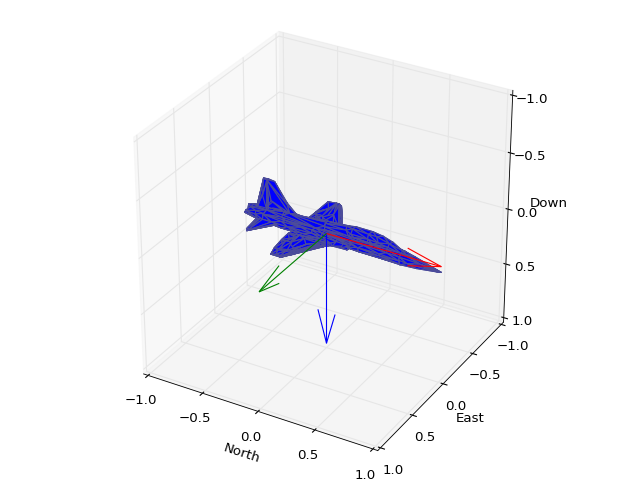

In [22]:
att = Attitude()
att.show('mrp')